In [65]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')

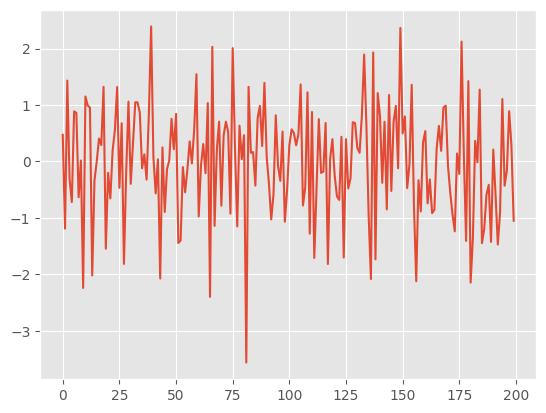

In [52]:
np.random.seed(1234)
# generate white noise for 200 observations and plot it
white_noise = np.random.normal(0, 1, 200)
plt.plot(white_noise)


In [53]:
# generate a white noise with mean 4 and sd 2 then use the arima function to estimate the parameters
white_noise = np.random.normal(4, 2, 200)
ARIMA(white_noise, order=(1, 0, 0)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -411.451
Date:                Mon, 26 Sep 2022   AIC                            828.901
Time:                        13:57:07   BIC                            838.796
Sample:                             0   HQIC                           832.905
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2558      0.135     31.528      0.000       3.991       4.520
ar.L1          0.0015      0.071      0.021      0.983      -0.137       0.140
sigma2         3.5845      0.361      9.938      0.000       2.878       4.291
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.84
Prob(Q):                              1.00   Prob(JB):                         0.66
Heteroskedasticity (H):               1.04   Skew:                             0.16
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Explain with your own words what a random walk is (minimum 100 words).

A random walk is a time series where the next value is dependent on the previous value. A white noise is a time series where the next value is independent of the previous value. 

## Explain with your own words what stationarity means for a time series

A stationary time series is a time series where the mean, variance and autocorrelation are constant over time.

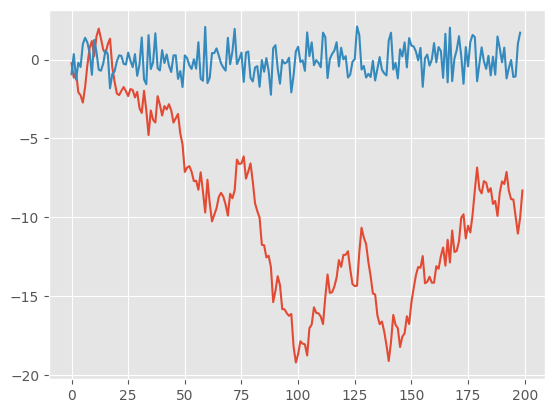

In [54]:
# Create a random walk series, plot it, calculate the first difference series and plot it
random_walk = np.cumsum(np.random.normal(0, 1, 200))
plt.plot(random_walk)
plt.plot(np.diff(random_walk))
plt.show()

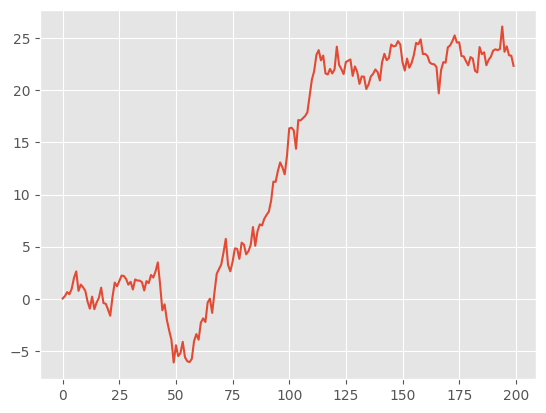

In [55]:
# Generate WN drift data, convert it to a random walk and plot it
white_noise_drift = np.cumsum(np.random.normal(0, 1, 200)) + (np.arange(200) / 10)
plt.plot(white_noise_drift)
plt.show()

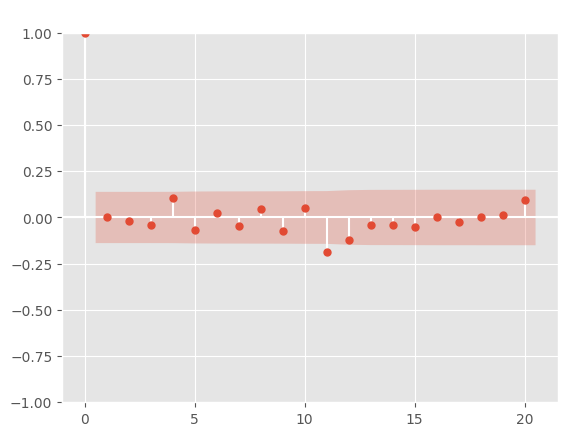

In [56]:
# Plot the ACF on the white noise.
plot_acf(white_noise, lags=20)
plt.show()

## What’s the characteristic of a white noise ACF ?

The ACF of a white noise is 0 for all lags. Moreover, they are never statistically significant.

In [57]:
# Perform a Ljung-Box Test. Command : Box.test in R, ljung is an option.
acorr_ljungbox(white_noise, lags=20)

,lb_stat,lb_pvalue
1,0.000420,0.983652
2,0.089287,0.956338
3,0.405949,0.939011
4,2.719443,0.605817
5,3.675847,0.596962
6,3.814349,0.701783
7,4.310992,0.743341
8,4.746905,0.784253
9,5.812366,0.758541
10,6.333611,0.786499


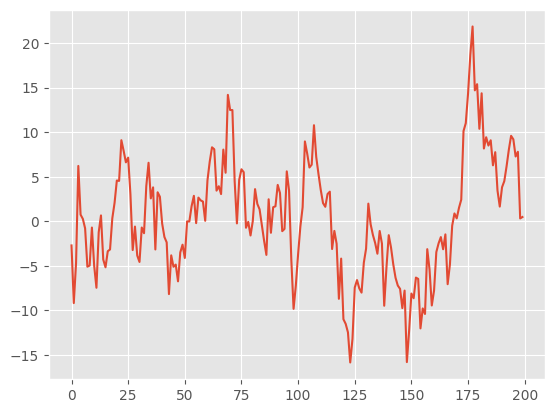

In [98]:
# Use the arima.sim function (or Python equivalent) to generate time series based on the autoregressive model, with slopes comprised between -1 and 1.
arima_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)
plt.show()

## What do you observe ?

The ACF of the random walk is not 0 for all lags. Moreover, they are statistically significant. also, the lags are positively correlated.


/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_13929/1852381461.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(arima_sim, lags=20).show()


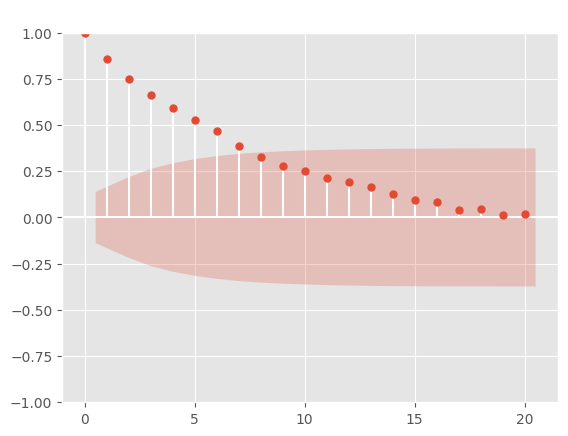

In [99]:
# Plot them, and the acf functions along with it.
plot_acf(arima_sim, lags=20).show()

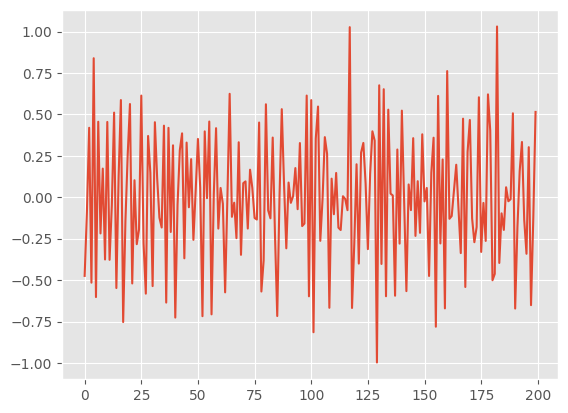

In [60]:
# Do the same with the moving average model. What do you observe ?
arima_sim = ArmaProcess(ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)

/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_13929/142294193.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(arima_sim, lags=20).show()


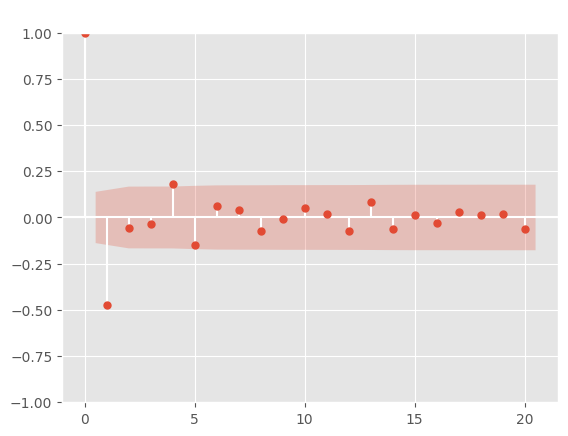

In [61]:
plot_acf(arima_sim, lags=20).show()

### What do you observe ?

The ACF of the MA simulation is not 0 for all lags. Moreover, they are statistically significant. also, the lags are negatively correlated.

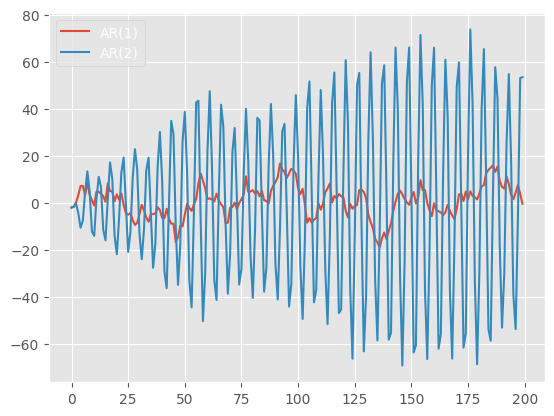

In [117]:
# Contrast AR(1) and AR(2) models. How do they differ ?

# AR(1)
arima_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)


# AR(2)
arima_sim = ArmaProcess(ar = [0.3, -0.25, 0.3]).generate_sample(nsample=200)
plt.plot(arima_sim)

plt.legend(['AR(1)', 'AR(2)'])
plt.show()


They differ by how the lags are correlated. The AR(2) model is more correlated to its 2 previous lags rather than the AR(1) model which is more correlated to only its first lag.

### What is the difference between an Autocorrelation Function and a Partial autocorrelation Function ? (Min. 150 words)

The ACF is the correlation between the time series and its lags. The PACF is the correlation between the time series and its lags, while controlling for the effect of the intermediate lags. The PACF is a better indicator of the order of the AR model. The PACF of an AR(1) model is 0 for all lags after the first lag. The PACF of an AR(2) model is 0 for all lags after the second lag.


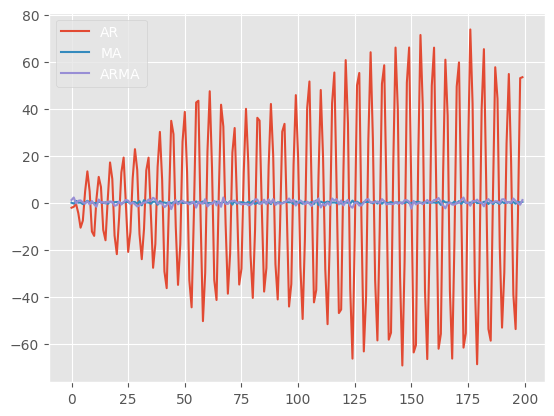

/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_13929/3432419348.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(ar_sim, lags=20).show()
/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_13929/3432419348.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(ma_sim, lags=20).show()
/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_13929/3432419348.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(arma_sim, lags=20).show()


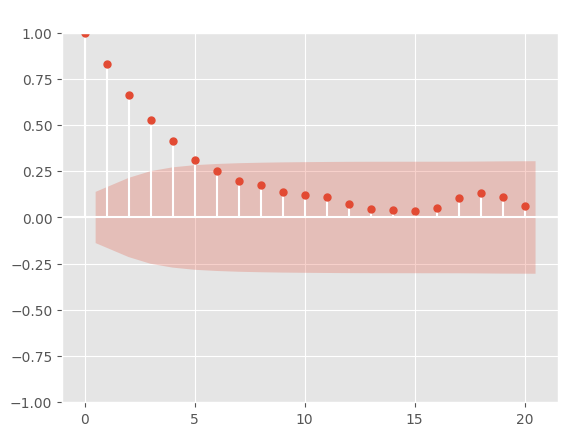

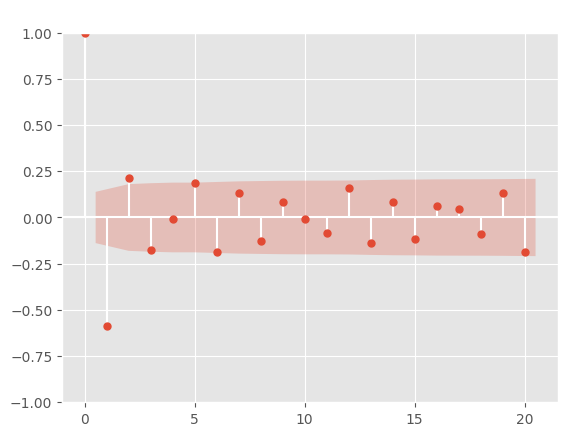

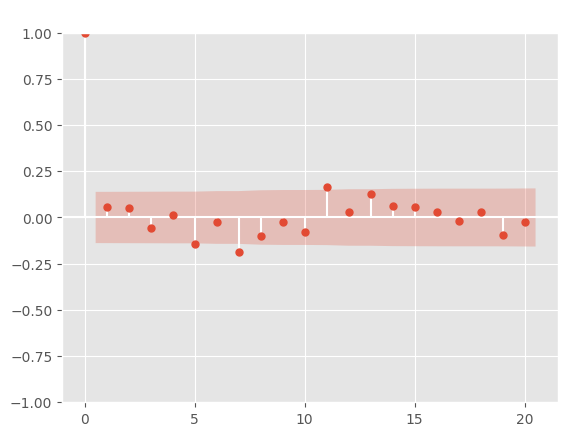

In [136]:
# Plot the ACF and the PACF of an AR, a MA, and ARMA models.
ar_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)

ma_sim = ArmaProcess(ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(ma_sim)

arma_sim = ArmaProcess(ar = [0.3, -0.25], ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arma_sim)

plt.legend(['AR', 'MA', 'ARMA'])
plt.show()

# Plot the ACF and the PACF of an AR, a MA, and ARMA models.
plot_acf(ar_sim, lags=20).show()
plot_acf(ma_sim, lags=20).show()
plot_acf(arma_sim, lags=20).show()


The main difference between the ACF and the PACF is that the PACF is a better indicator of the order of the AR model. The PACF of an AR(1) model is 0 for all lags after the first lag. The PACF of an AR(2) model is 0 for all lags after the second lag.

### Write the equation of an ARMA model

$$X_t = \mu + \epsilon_t + \sum_{i=1}^p \phi_i X_{t-i} + \sum_{i=1}^q \theta_i \epsilon_{t-i}$$

### What are the main differences between AIC and BIC criteria, conceptually speaking ? Elaborate (Min. 100 words).

The AIC criterion is the log-likelihood of the model plus a penalty term. The BIC criterion is the log-likelihood of the model plus a penalty term. The penalty term is higher for the BIC criterion. The AIC criterion is more suitable for small sample sizes, while the BIC criterion is more suitable for large sample sizes.
